In [4]:
import jax
import numpy as onp
import jax.numpy as jnp
import optax
import chex
import haiku as hk
from tqdm import tqdm
import matplotlib.pyplot as plt

# Plotting Functions

In [5]:
def plot_gradients(params, data, xlim=(-1.5, 2.0), ylim=(-1.5, 2.0), nx=50, ny=50, plot_scatter=True, alpha=1.0):
    xx = onp.stack(onp.meshgrid(onp.linspace(*xlim, nx), onp.linspace(*ylim, ny)), axis=-1).reshape(-1, 2)
    scores = m_apply(params, xx)
    scores_norm = onp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * onp.log1p(scores_norm)
    # Perform the plots

    if plot_scatter:
        plt.figure(figsize=(16,12))
        plt.scatter(data[:, 0], data[:, 1], alpha=0.3, color='red', edgecolor='black', s=40)
        plt.xlim(*xlim)
        plt.ylim(*ylim)

    quiver = plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='black', alpha=alpha)

    return quiver

# Create the Data

In [6]:
points1 = onp.stack([onp.random.normal((1, 1), 1) for x in range(500)])
points2 = onp.stack([onp.random.normal((50, 50), 5) for x in range(2000)])

In [9]:
data = onp.vstack([points1, points2])
onp.random.shuffle(data)

## Plot the Data

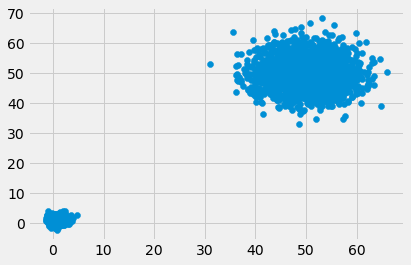

In [10]:
plt.style.use('fivethirtyeight')
plt.scatter(data[:, 0], data[:, 1])

# Model Definition

In [29]:
# Create a general model for the score
class MLP(hk.Module):
    def __init__(self, num_layers, hidden_size, output_size, name='score_mlp'):
        super(MLP, self).__init__(name=name)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size

    def __call__(self, x):
        p = x
        for i in range(self.num_layers - 1):
            p = hk.Linear(self.hidden_size)(p)
            p = jax.nn.softplus(p)
        p = hk.Linear(self.output_size)(p)
        return p

m_init, m_apply = hk.without_apply_rng(hk.transform(lambda x: MLP(3, 128, 2)(x)))

In [34]:
key =jax.random.PRNGKey(7)
key, split = jax.random.split(key)
m_params = m_init(key, data[:10])

# create and initialize the optimizer
optim = optax.adamw(0.003)
opt_state = optim.init(m_params)

/home/anique/.local/lib/python3.10/site-packages/haiku/_src/base.py:497: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)
/home/anique/.local/lib/python3.10/site-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/home/anique/.local/lib/python3.10/site-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)


# Denoising Score Matching
The idea here is to add noise to the original data points and then train a model to predict the original data from the noise.
i.e. We create the distribution $q_\sigma(\tilde{x} |x) = \mathcal{N}(\tilde{x}|x, \sigma^2 I)$

then,
$$\nabla_\tilde{x}q_\sigma(\tilde{x}|x) = \frac{\tilde{x} - x}{\sigma^2}$$


In [35]:
# Create a simple model to estimate the score (Denoising Score Matching)
def score_loss(params, key, x, sigma):
    key, split = jax.random.split(key)
    noise = jax.random.normal(split, x.shape)
    perturbed = x + noise * sigma
    target = - noise * sigma
    # target = - noise * sigma # TODO Why is this division instead of multiplication?
    preds = m_apply(params, perturbed)
    loss = 0.5 * ((preds - target) ** 2).sum(axis=-1).mean(axis=0)
    return loss

score_loss_value_grad = jax.jit(jax.value_and_grad(score_loss))

In [36]:
NUM_ITERATIONS = 2000


for i in range(NUM_ITERATIONS):
    # Get a random batch of data
    batch_idxs = onp.random.choice(data.shape[0], size=128, replace=False)

    key, split = jax.random.split(key)
    # Get the loss
    loss_value, grads = score_loss_value_grad(m_params, split, data[batch_idxs], 20.)
    # optimize
    updates, opt_state = optim.update(grads, opt_state, m_params)
    m_params = optax.apply_updates(m_params, updates)

    # Print results
    if (i % 100) == 0:
        print(f'score matching loss: {loss_value}')

score matching loss: 610.8748168945312
score matching loss: 174.77313232421875
score matching loss: 131.46661376953125
score matching loss: 139.90689086914062
score matching loss: 162.3185272216797
score matching loss: 125.87757873535156
score matching loss: 114.90554809570312
score matching loss: 107.19735717773438
score matching loss: 88.8173828125
score matching loss: 74.49507141113281
score matching loss: 75.23880767822266
score matching loss: 101.99510192871094
score matching loss: 58.088985443115234
score matching loss: 97.73823547363281
score matching loss: 60.274906158447266
score matching loss: 74.56848907470703
score matching loss: 51.0096435546875
score matching loss: 59.41799545288086
score matching loss: 73.21693420410156
score matching loss: 71.06592559814453


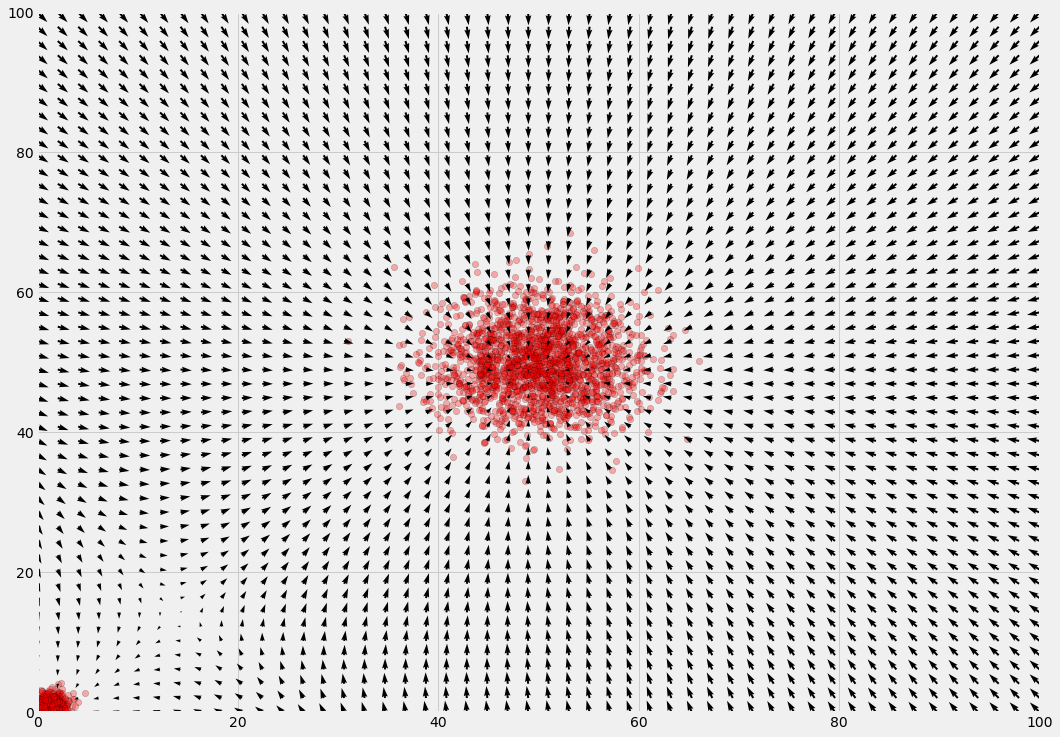

In [37]:
plot_gradients(m_params, data, xlim=(0,100), ylim=(0, 100))